In [2]:
import os
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py

import math
import ephem
from datetime import datetime, time, timedelta
from math import pi, cos, sin
from scipy import optimize
from joblib import Parallel, delayed
from mpl_toolkits.basemap import Basemap
# import xesmf as xr

# from diurnal_utils import *
%run diurnal_utils.py

In [4]:
start_date = '2000-06'
# end_date =  '2010-06'
end_date =  '2001-06'

In [5]:
save_output_dir = '/export/data1/cchristo/diurnal_analysis_results/GPM/'
save_figs_dir = '/home/cchristo/proj_tapio/figs/diurnal_cycle_figs/gpm_2000_2010_precip/'

In [6]:
# model_dir = '/export/data1/cchristo/gpm_data/gpmdata/'
model_dir = '/export/data1/cchristo/gpm_data/gpmdata_regridded_gfdl_cm4/'
years_to_include = ('2000', '2001')
# years_to_include = range(2000, 2001)

result = [y for x in os.walk(model_dir) for y in glob(os.path.join(x[0], '*.nc'))]

# filter paths based on year
result_filt =[]
for path_i in result: 
    if (os.path.dirname(path_i).split('/')[-4] in years_to_include):
        result_filt.append(path_i)

# get only certain years
# result = sorted(result)
result = sorted(result_filt)

In [8]:
%%time
ds = xr.open_mfdataset(result, combine='nested', concat_dim = 'time')
# ds = xr.open_dataset(result[0],  engine = 'h5netcdf')

CPU times: user 3min 21s, sys: 6.5 s, total: 3min 27s
Wall time: 6min 12s


In [9]:
ds = ds.sel(time = slice(start_date, end_date))
ds = ds.sel(lat= slice(-60, 60))
# ds.load()
# print('Dataset Loaded')

In [10]:
# ds['precipitationCal'].fillna(0)


In [ ]:
# ds_mean = ds['precipitationCal'].mean(dim = 'time')
# ds_mean.load()

# ds_max = ds['precipitationCal'].mean(dim = 'time')
# ds_max.load()


In [ ]:
# ds_mean.plot.imshow(vmin =0, vmax = 1, cmap = plt.get_cmap('gist_ncar'))
# ds_max.plot.imshow(vmin =0, vmax = 0.25 , cmap = plt.get_cmap('gist_ncar'))

In [ ]:
# ds_mean.plot.imshow(vmin =0, vmax = 2, cmap = plt.get_cmap('gist_ncar'))

In [ ]:
# ds.isel(time = 0)['precipitationCal'].plot.imshow(vmin =0, vmax = 10)

In [ ]:
# ds['precipitationCal']

In [15]:
grid_time_resolution_hours = 0.5
time_resolution_hours = 0.5
field_id = 'precipitationCal'


hour_bins = np.arange(time_resolution_hours, 24 + time_resolution_hours, time_resolution_hours)
grid_hour_bins = np.arange(grid_time_resolution_hours, 24 + grid_time_resolution_hours, grid_time_resolution_hours)

lon_mesh, lat_mesh = np.meshgrid(ds['lon'].values, ds['lat'].values)
ds_seasons = ds.groupby('time.season')

mu_season = {}
sigma_season = {}
ampl_season = {}
phase_season = {}
average_cycle_season = {}

for season_i, season_ds in ds_seasons:
#     if season_i != 'DJF':
#         break
    print(season_i)
    lst_da = compute_lst_array(season_ds, 
                               bin_interval = grid_time_resolution_hours, # time_resolution_hours,
                               bin_bool = True, 
                               lon_mesh = lon_mesh, 
                               lat_mesh = lat_mesh,
                               field_id = field_id)
    lst_array = lst_da.values
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds[field_id].values

#         field_season_mean = field_season_array.mean(axis = 0)

    # compute mu_ij
#         mu_ij = np.zeros(field_season_array.shape[-2:])
    mu_ij = np.zeros(field_season_array.shape[-2:])
#         sigma_ij = np.zeros((len(hour_bins),) + field_season_array.shape[-2:])

    f_bar_ks = {}
    for hour_i in grid_hour_bins:
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        f_bar_ks[hour_i] = f_bar_k
        mu_ij  += f_bar_k

    hour_means = np.stack(list(f_bar_ks.values()))
    average_cycle_season[season_i] = hour_means


#     mu_ij = (1/len(grid_hour_bins))*mu_ij
# #         mu_ij = (1/8)*mu_ij
#     mu_season[season_i] = mu_ij

#     sigma_ij = np.zeros(field_season_array.shape[-2:])
#     for hour_i in grid_hour_bins:
#         masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

#         # mean for a given season, LST
#         f_bar_k = np.nanmean(masked_field, axis = 0)
#         f_bar_k[np.isnan(f_bar_k)] = 0
#         sigma_ij += np.square(f_bar_k - mu_ij)

#     sigma_ij = np.sqrt((1/(len(grid_hour_bins) - 1))*sigma_ij)
# #         sigma_ij = np.sqrt((1/7)*sigma_ij)
# #         sigma_ij = np.nanstd(sigma_ij, axis = 0)

#     sigma_season[season_i] = sigma_ij

#     lst_da = compute_lst_array(season_ds, 
#                                bin_interval = time_resolution_hours,
#                                bin_bool = True, 
#                                lon_mesh = lon_mesh, 
#                                lat_mesh = lat_mesh,
#                                field_id = field_id)
#     lst_array = lst_da.values
#     del lst_da
#     lst_array[lst_array == 0] = 24
#     field_season_array = season_ds[field_id].values

# #         field_season_mean = field_season_array.mean(axis = 0)

#     # compute hourly grid means needed for cos fit
#     f_bar_ks = {}
#     for ii in range(len(hour_bins)):
#         hour_i = hour_bins[ii]
#         masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

#         # mean for a given season, LST
#         f_bar_k = np.nanmean(masked_field, axis = 0)
#         f_bar_ks[hour_i] = f_bar_k

#     hour_means = np.stack(list(f_bar_ks.values()))

#     print('Performing Cos Fit')
# #         res = cos_fit_grid(field_season_array, lst_array, hour_means, hour_bins)
#     res = cos_fit_grid_average(hour_means, hour_bins)
#     print('Finished Cos Fit')
#     ampl_season[season_i], phase_season[season_i] = res[0], res[1]

#     # make results into dataarrays
#     out_ds = xr.Dataset()
#     out_ds['mu_season'] = make_da_from_dict(mu_season, ds)
#     out_ds['sigma_season'] = make_da_from_dict(sigma_season,ds)
#     out_ds['ampl_season'] = make_da_from_dict(ampl_season, ds)
#     out_ds['phase_season'] = make_da_from_dict(phase_season,ds)

    out_ds_means = xr.Dataset()
    out_ds_means = make_da_from_dict_time(average_cycle_season, ds, grid_hour_bins)
    out_ds_means = out_ds_means.to_dataset(name = field_id + '_mean')

DJF


100%|██████████| 4320/4320 [00:07<00:00, 564.86it/s]


JJA


100%|██████████| 5856/5856 [00:10<00:00, 563.95it/s]


MAM


100%|██████████| 4416/4416 [00:07<00:00, 579.47it/s]


SON


100%|██████████| 4368/4368 [00:07<00:00, 567.21it/s]


(48, 120, 288)


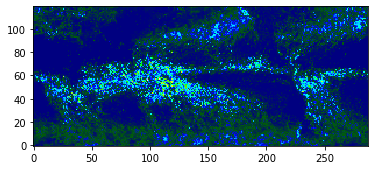

In [14]:
print(hour_means.shape)
plt.imshow(hour_means[2,:,:], origin = 'lower', cmap = plt.get_cmap('gist_ncar'))

In [18]:
out_ds_means

<xarray.Dataset>
Dimensions:                (lat: 120, lon: 288, season: 4, time: 48)
Coordinates:
  * season                 (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
  * time                   (time) float64 0.5 1.0 1.5 2.0 ... 23.0 23.5 24.0
  * lon                    (lon) float64 0.625 1.875 3.125 ... 356.9 358.1 359.4
  * lat                    (lat) float64 -59.5 -58.5 -57.5 ... 57.5 58.5 59.5
Data variables:
    precipitationCal_mean  (season, time, lat, lon) float64 0.06582 ... 0.1813

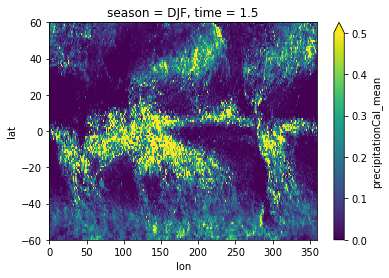

In [29]:
out_ds_means['precipitationCal_mean'].isel(time = 2, season = 0).plot.imshow(vmax = 0.5)

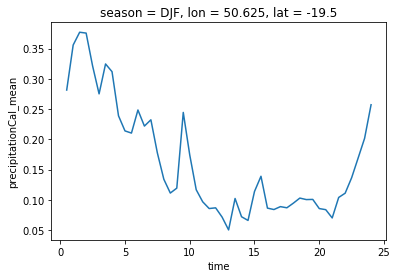

In [30]:
out_ds_means['precipitationCal_mean'].isel(season = 0).isel(lat = 40, lon = 40).plot()

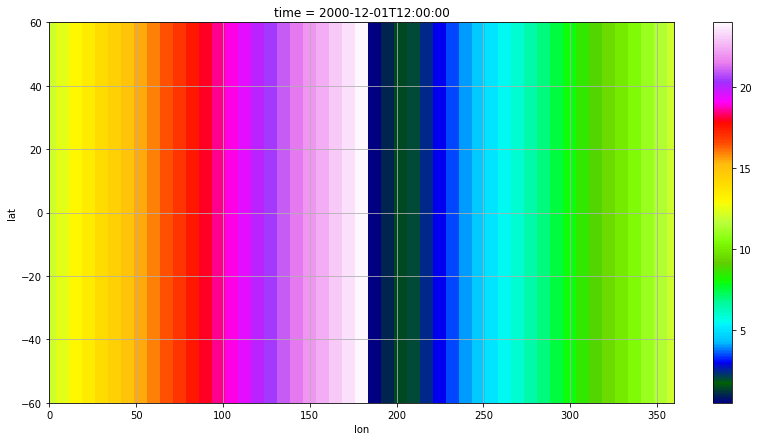

In [104]:
# lst_da.isel(time = 0).plot.imshow(cmap = plt.get_cmap('gist_ncar'))
plt.figure(figsize = (14,7))
# plt.imshow(lst_da.isel(time = 23).values, cmap = plt.get_cmap('gist_ncar'))
lst_da.isel(time = 24).plot.imshow(cmap = plt.get_cmap('gist_ncar'))
plt.grid()

In [108]:
lst_da

<xarray.DataArray (time: 4320, lat: 120, lon: 288)>
array([[[24., 24., 24., ..., 24., 24., 24.],
        [24., 24., 24., ..., 24., 24., 24.],
        [24., 24., 24., ..., 24., 24., 24.],
        ...,
        [24., 24., 24., ..., 24., 24., 24.],
        [24., 24., 24., ..., 24., 24., 24.],
        [24., 24., 24., ..., 24., 24., 24.]],

       [[24., 24., 24., ..., 24., 24., 24.],
        [24., 24., 24., ..., 24., 24., 24.],
        [24., 24., 24., ..., 24., 24., 24.],
        ...,
        [24., 24., 24., ..., 24., 24., 24.],
        [24., 24., 24., ..., 24., 24., 24.],
        [24., 24., 24., ..., 24., 24., 24.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       ...,

       [[22., 22., 22., ..., 22., 22., 22.],
        [22., 22., 22., ..., 22., 22., 22.],
        [22., 22., 22., ..., 22., 22., 22.],
        ...,
        [22., 22., 22., ..., 22., 22., 22.],
        [22., 22., 22., ..., 22., 22., 22.],
        [22., 22., 22., ..., 22., 22., 22.]],

       [[23., 23., 23., ..., 23., 23., 23.],
        [23., 23., 23., ..., 23., 23., 23.],
        [23., 23., 23., ..., 23., 23., 23.],
        ...,
        [23., 23., 23., ..., 23., 23., 23.],
        [23., 23., 23., ..., 23., 23., 23.],
        [23., 23., 23., ..., 23., 23., 23.]],

       [[23., 23., 23., ..., 23., 23., 23.],
        [23., 23., 23., ..., 23., 23., 23.],
        [23., 23., 23., ..., 23., 23., 23.],
        ...,
        [23., 23., 23., ..., 23., 23., 23.],
        [23., 23., 23., ..., 23., 23., 23.],
        [23., 23., 23., ..., 23., 23., 23.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-12-01 ... 2001-02-28T23:30:00
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * lat      (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ... 56.5 57.5 58.5 59.5

In [ ]:
calc_solar_time(utc_time, 
                    longitude, 
                    bin_interval = 3, 
                    bin_bool = True)

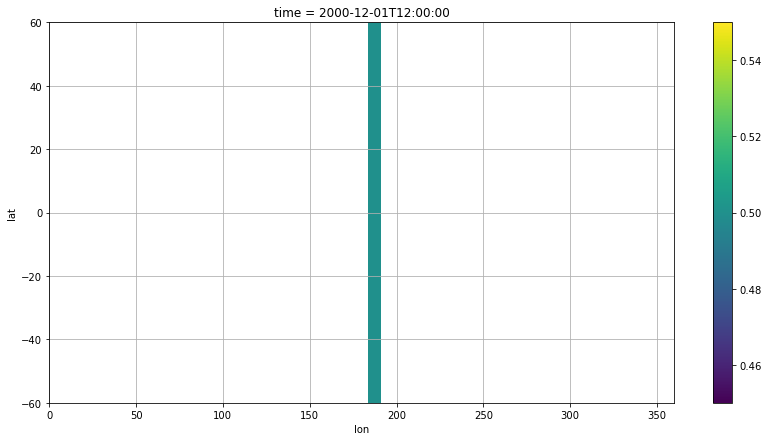

In [107]:
plt.figure(figsize = (14,7))
lst_da_time = lst_da.isel(time = 24)
lst_da_time.where(lst_da_time == grid_hour_bins[0]).plot.imshow()
plt.grid()

In [8]:

out_ds, out_ds_means = diurnal_analysis(ds, 
                                        field_id = 'precipitationCal', 
                                        grid_time_resolution_hours = 0.5,
                                        time_resolution_hours = 0.5)

  1%|▏         | 58/4320 [00:00<00:07, 579.50it/s]

DJF


100%|██████████| 4320/4320 [00:07<00:00, 582.39it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:215: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:233: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
100%|██████████| 4320/4320 [00:07<00:00, 567.85it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:262: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


100%|██████████| 120/120 [02:08<00:00,  1.07s/it]


Finished Cos Fit


  1%|          | 58/5856 [00:00<00:10, 570.77it/s]

JJA


100%|██████████| 5856/5856 [00:10<00:00, 571.16it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:215: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:233: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
100%|██████████| 5856/5856 [00:10<00:00, 567.27it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:262: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


100%|██████████| 120/120 [02:07<00:00,  1.06s/it]


Finished Cos Fit


  1%|▏         | 57/4416 [00:00<00:07, 567.89it/s]

MAM


100%|██████████| 4416/4416 [00:07<00:00, 558.71it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:215: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:233: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
100%|██████████| 4416/4416 [00:07<00:00, 553.94it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:262: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


100%|██████████| 120/120 [02:18<00:00,  1.16s/it]


Finished Cos Fit


  1%|          | 54/4368 [00:00<00:08, 535.35it/s]

SON


100%|██████████| 4368/4368 [00:08<00:00, 530.54it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:215: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:233: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
100%|██████████| 4368/4368 [00:08<00:00, 528.85it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:262: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


100%|██████████| 120/120 [02:18<00:00,  1.15s/it]


Finished Cos Fit


In [9]:
out_ds.to_netcdf(save_output_dir + start_date + '_' + end_date + '_precip.nc')
out_ds_means.to_netcdf(save_output_dir + start_date + '_' + end_date + '_precip_diurnal_means.nc')

In [ ]:
# make_four_panel(mu_season , 
# #                 cmap = plt.get_cmap('bwr'),
#                 cmap = plt.get_cmap('gist_ncar'),
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0,
#                 vmax = 0.8,
#                 title = r'$\mu$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= save_figs_dir + 'GFDL_CM4_means_pr.png')

In [ ]:
# make_four_panel(sigma_season , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 0.2, 
# #                 cmap = plt.get_cmap('bwr'),
#                 cmap = plt.get_cmap('gist_ncar'),
#                 title = r'$\sigma$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= save_figs_dir + 'GFDL_CM4_stds_pr.png')

In [ ]:
# make_four_panel(ampl_season , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
# #                 vmax = 0.00003, 
# #                 cmap = plt.get_cmap('bwr'),
#                 cmap = plt.get_cmap('gist_ncar'),
#                 title = r'$A$',
#                 vmin = 0, vmax = 0.2,
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= save_figs_dir + 'GFDL_CM4_ampl_pr.png')

In [ ]:
# make_four_panel(phase_season , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
# #                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= save_figs_dir + 'GFDL_CM4_phase_pr.png')

In [18]:
# out_ds = xr.Dataset()
# out_ds['mu_season'] = make_da_from_dict(mu_season, ds)
# out_ds['sigma_season'] = make_da_from_dict(sigma_season, ds)
# out_ds['ampl_season'] = make_da_from_dict(ampl_season, ds)
# out_ds['phase_season'] = make_da_from_dict(phase_season, ds)

In [22]:
# out_ds.to_netcdf(save_output_dir + 'gpm_2000_2010_precip.nc')